<a href="https://colab.research.google.com/github/andreidm92/computer_vision_tasks/blob/main/practice/Feature_Matching_ORB_SuperPoint_Lesson_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 🧠 Теория: ORB (Oriented FAST and Rotated BRIEF)


ORB — это комбинация:
- **FAST** — для детектирования углов (keypoints)
- **BRIEF** — бинарный дескриптор
- + ориентация через **моменты** для устойчивости к поворотам

### 🔹 FAST (Features from Accelerated Segment Test)

Определяет ключевые точки, если **12 и более** пикселей на окружности ярче или темнее центра:

$$
\text{keypoint}(p) \iff \exists S \subset C, |S| \geq 12, \forall q \in S, |I(q) - I(p)| > t
$$

---

### 🔹 BRIEF — бинарный дескриптор

Для каждой пары пикселей $ (p_i, q_i) $ в окрестности:

$$
\text{desc}_i =
\begin{cases}
1, & \text{если } I(p_i) < I(q_i) \\
0, & \text{иначе}
\end{cases}
$$

128 или 256 таких сравнений → дескриптор

---

### 🔹 Ориентация через моменты

Для устойчивости к повороту вычисляется угол:

$$
\theta = \frac{1}{2} \arctan\left(\frac{2\mu_{11}}{\mu_{20} - \mu_{02}}\right)
$$

Где моменты:
$$
\mu_{pq} = \sum (x - \bar{x})^p (y - \bar{y})^q I(x, y)
$$

Далее координаты сравниваемых точек поворачиваются на $ \theta $.



## 🤖 Теория: SuperPoint


SuperPoint использует сверточную нейросеть, обученную находить:
- **Keypoints** — как карта тепловых максимумов
- **Dense дескрипторы** — вектор признаков для каждой точки

---

### 📐 Архитектура:

1. Вход: grayscale изображение → CNN-экстрактор
2. Два выхода:
   - $ H \times W \times 65 $ — logits для keypoints (softmax → heatmap)
   - $ H \times W \times D $ — дескрипторы (обычно $ D = 256 $)

---

### 🔍 Преимущества:

- Обучена end-to-end
- Устойчива к шуму, искажениям, повороту, масштабу
- Работает лучше классических методов на сложных сценах

---

### Пример дескриптора:

Сравнение дескрипторов делается через L2 или косинусное расстояние:

$$
\text{distance}(a, b) = \sqrt{\sum (a_i - b_i)^2}
$$

или

$$
\cos(\theta) = \frac{a \cdot b}{\|a\| \cdot \|b\|}
$$



# 🧠 Feature Matching: ORB + SuperPoint — Lesson 5


В этом уроке мы разберем два подхода к сопоставлению ключевых точек между изображениями:
- **ORB** — быстрый классический метод с бинарными дескрипторами
- **SuperPoint** — современный глубокий подход

---

## 🔍 Цели урока:
- Понять, как работают ORB и SuperPoint
- Научиться извлекать дескрипторы и находить совпадения
- Понять роль моментов и Hamming distance
- Применить знания линейной алгебры (центральные моменты, угол ориентации)


## 🧠 Теория: ORB (Oriented FAST and Rotated BRIEF)


ORB — это комбинация:
- **FAST** — для детектирования углов (keypoints)
- **BRIEF** — бинарный дескриптор
- + ориентация через **моменты** для устойчивости к поворотам

Преимущества:
- Быстрый
- Небольшой размер дескриптора (256 бит)
- Можно сравнивать через Hamming distance


## 🔧 Практика: ORB + BFMatcher

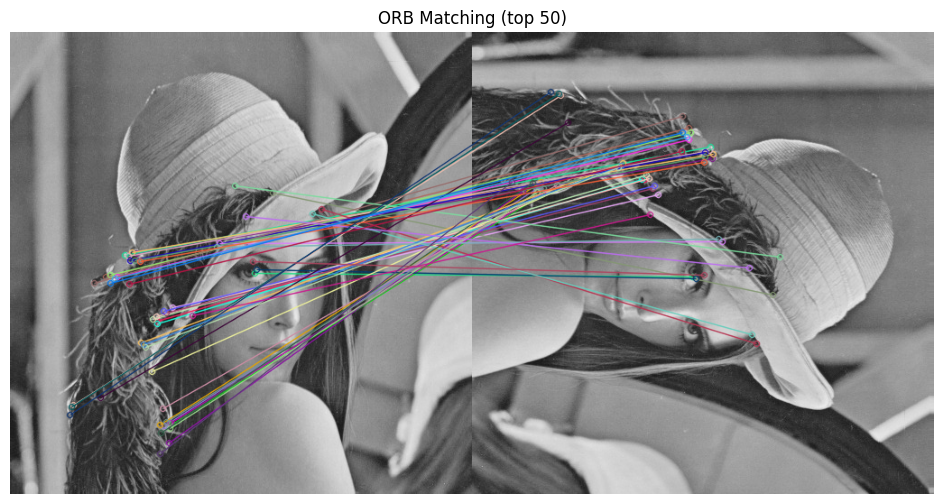

In [1]:
import cv2
import numpy as np
import urllib.request
import matplotlib.pyplot as plt

# Загружаем изображение по URL
url = 'https://raw.githubusercontent.com/opencv/opencv/master/samples/data/lena.jpg'
resp = urllib.request.urlopen(url)
image_data = np.asarray(bytearray(resp.read()), dtype="uint8")
img1 = cv2.imdecode(image_data, cv2.IMREAD_GRAYSCALE)

# Поворачиваем второе изображение
img2 = cv2.rotate(img1, cv2.ROTATE_90_CLOCKWISE)

# ORB
orb = cv2.ORB_create(nfeatures=500)
kp1, des1 = orb.detectAndCompute(img1, None)
kp2, des2 = orb.detectAndCompute(img2, None)

# Сопоставление
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(des1, des2)
matches = sorted(matches, key=lambda x: x.distance)

# Визуализация
matched_img = cv2.drawMatches(img1, kp1, img2, kp2, matches[:50], None, flags=2)

plt.figure(figsize=(14,6))
plt.imshow(matched_img, cmap='gray')
plt.axis('off')
plt.title("ORB Matching (top 50)")
plt.show()



##Объяснение блока ORB Matching

В этом фрагменте кода происходит сопоставление ключевых точек между двумя изображениями с помощью алгоритма ORB (Oriented FAST and Rotated BRIEF).

###Инициализация ORB


orb = cv2.ORB_create(nfeatures=500)
Создаётся ORB-объект, который будет находить до 500 ключевых точек с дескрипторами. Он использует FAST для детекции и BRIEF для построения бинарных дескрипторов.


###Извлечение признаков


kp1, des1 = orb.detectAndCompute(img1, None)

kp2, des2 = orb.detectAndCompute(img2, None)

ORB извлекает:

kp1, kp2: список ключевых точек (объекты с координатами, ориентацией и масштабом)

des1, des2: дескрипторы (по 256 бит = 32 байта на точку)


###Сопоставление дескрипторов (matching)


bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

matches = bf.match(des1, des2)

matches = sorted(matches, key=lambda x: x.distance)

Используется Brute-Force сопоставление с метрикой Hamming (подходит для бинарных дескрипторов).


crossCheck=True гарантирует, что совпадения взаимные.
Затем совпадения сортируются по расстоянию (чем меньше, тем лучше).


### Визуализация совпадений


matched_img = cv2.drawMatches(img1, kp1, img2, kp2, matches[:50], None, flags=2)
Отрисовываются линии между совпадающими точками на двух изображениях. Используются только 50 лучших совпадений.



## 🤖 Теория: SuperPoint


SuperPoint — это нейросетевой подход, который объединяет:
- **Keypoint detector** (через softmax heatmap)
- **Descriptor extractor** (через dense дескрипторы)

Преимущества:
- Устойчив к поворотам и масштабам
- Работает end-to-end
- Требует PyTorch и предобученную модель



## 🔧 Практика: SuperPoint

## ⚙️ Практика: SuperPoint (через GitHub)


Для запуска SuperPoint в Google Colab, мы клонируем готовый репозиторий с предобученной моделью.

📦 Используем: https://github.com/magicleap/SuperPointPretrainedNetwork


In [2]:

# Клонируем репозиторий и заходим в него
!git clone https://github.com/magicleap/SuperPointPretrainedNetwork.git
%cd SuperPointPretrainedNetwork

# Устанавливаем зависимости
!pip install opencv-python scipy



Cloning into 'SuperPointPretrainedNetwork'...
remote: Enumerating objects: 81, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 81 (delta 12), reused 9 (delta 9), pack-reused 66 (from 1)
Receiving objects: 100% (81/81), 56.61 MiB | 45.14 MiB/s, done.
Resolving deltas: 100% (21/21), done.
/content/SuperPointPretrainedNetwork


--2025-05-03 13:25:19--  https://raw.githubusercontent.com/opencv/opencv/master/samples/data/lena.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 91814 (90K) [image/jpeg]
Saving to: ‘lena.png’

lena.png            100%[===================>]  89.66K  --.-KB/s    in 0.01s   

2025-05-03 13:25:19 (7.41 MB/s) - ‘lena.png’ saved [91814/91814]

[Errno 2] No such file or directory: 'SuperPointPretrainedNetwork'
/content/SuperPointPretrainedNetwork
Namespace(input='lena.png', weights_path='superpoint_v1.pth', img_glob='*.png', skip=1, show_extra=False, H=480, W=640, display_scale=2, min_length=2, max_length=5, nms_dist=4, conf_thresh=0.015, nn_thresh=0.7, camid=0, waitkey=1, cuda=False, no_display=True, write=True, write_dir='out')
==> Processing Video Input.
==

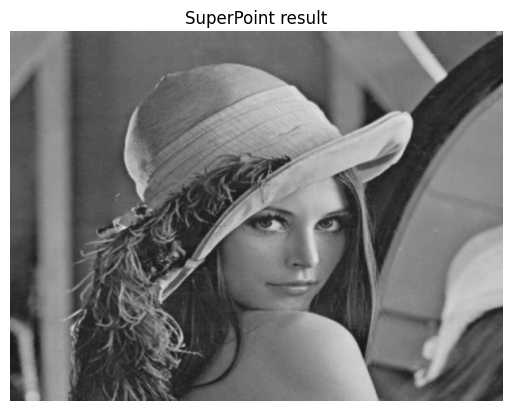

In [3]:
# Скачиваем изображение
!wget https://raw.githubusercontent.com/opencv/opencv/master/samples/data/lena.jpg -O lena.png

# Переходим в проект
%cd SuperPointPretrainedNetwork

# Создаём папку для вывода
!mkdir -p out

# Запускаем без GUI и с сохранением
!python demo_superpoint.py lena.png --H 480 --W 640 --no_display --write --write_dir out

from PIL import Image
import matplotlib.pyplot as plt

img = Image.open("out/frame_00001.png")  # правильное имя файла
plt.imshow(img)
plt.axis('off')
plt.title("SuperPoint result")
plt.show()



In [ ]:

# Для запуска SuperPoint потребуется подключить реализацию с GitHub или HuggingFace
# Здесь можно использовать репозиторий: https://github.com/magicleap/SuperPointPretrainedNetwork
# или https://github.com/eric-yyjau/pytorch-superpoint

# Скачивание и инициализация модели делается отдельно


🧠 Что такое SuperPoint?
SuperPoint — это сверточная нейросеть, обученная в режиме самоконтроля, которая одновременно выполняет:

Детекцию ключевых точек: определяет интересные и стабильные точки на изображении.

Описание ключевых точек: для каждой точки создаёт дескриптор — вектор признаков, описывающий локальный патч изображения.

Эти ключевые точки и дескрипторы используются в задачах сопоставления изображений, SLAM, 3D-восстановления и других.

🛠️ Установка и подготовка
Для начала установим необходимые библиотеки и клонируем репозиторий с реализацией SuperPoint:



In [4]:
# Установка зависимостей
!pip install torch torchvision opencv-python


# Клонирование репозитория
!git clone https://github.com/eric-yyjau/pytorch-superpoint.git
%cd pytorch-superpoint


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 59.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 34.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 87.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

📥 Загрузка изображения
Загрузим изображение, которое будем использовать:

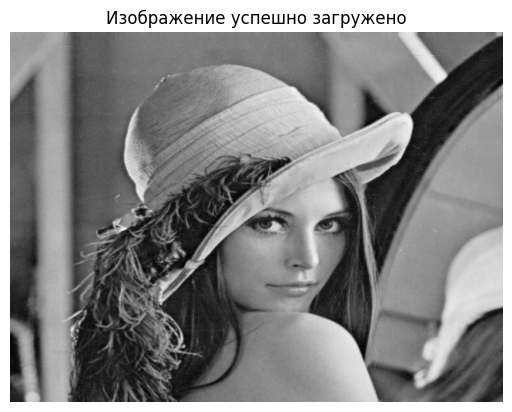

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

import cv2
import numpy as np
import urllib.request
import matplotlib.pyplot as plt

# Загружаем изображение по URL правильно
url = "https://raw.githubusercontent.com/opencv/opencv/master/samples/data/lena.jpg"
resp = urllib.request.urlopen(url)
image_data = np.asarray(bytearray(resp.read()), dtype="uint8")
img = cv2.imdecode(image_data, cv2.IMREAD_GRAYSCALE)

# Изменим размер
img = cv2.resize(img, (640, 480))

# Проверка
plt.imshow(img, cmap='gray')
plt.title("Изображение успешно загружено")
plt.axis('off')
plt.show()


🧩 Загрузка модели SuperPoint
Теперь загрузим модель SuperPoint и подготовим изображение для обработки:

In [6]:
# Убеждаемся, что всё на месте
!ls models


classical_detectors_descriptors.py  SubpixelNet.py
homographies.py			    SuperPointNet_gauss2.py
__init__.py			    SuperPointNet_pretrained.py
model_utils.py			    SuperPointNet.py
model_wrap.py			    unet_parts.py


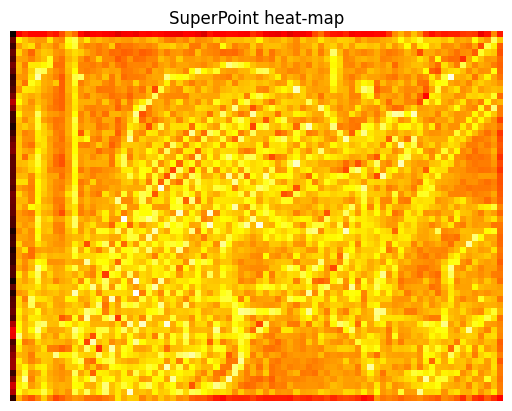

In [7]:
# --- 4. SuperPoint -----------------------------------------------------------
import torch, sys
sys.path.append('./')                       # путь к cloned‑репо

from models.SuperPointNet_pretrained import SuperPointNet

net = SuperPointNet()                       # веса подгрузим ниже
net.load_state_dict(torch.load('pretrained/superpoint_v1.pth',
                               map_location='cpu'))
net.eval()

# --- 5. прогон ---------------------------------------------------------------
with torch.no_grad():
    inp   = torch.from_numpy(img/255.).float().unsqueeze(0).unsqueeze(0)  # 1×1×H×W
    semi, desc = net(inp)             # ⬅️  распаковываем кортеж

# --- 6. визуализация теплокарты ---------------------------------------------
heatmap = semi[0, 0].cpu()            # первый «канал» карты вероятностей
plt.imshow(heatmap, cmap='hot'); plt.axis('off')
plt.title('SuperPoint heat‑map'); plt.show()



## 📐 Линейная алгебра: ориентация через моменты

In [8]:

import numpy as np

def orientation_angle(patch):
    h, w = patch.shape
    X, Y = np.meshgrid(np.arange(w), np.arange(h))

    M = patch.sum()
    x_bar = (X * patch).sum() / M
    y_bar = (Y * patch).sum() / M

    mu20 = ((X - x_bar)**2 * patch).sum()
    mu02 = ((Y - y_bar)**2 * patch).sum()
    mu11 = ((X - x_bar)*(Y - y_bar) * patch).sum()

    theta = 0.5 * np.arctan2(2 * mu11, mu20 - mu02)
    return np.degrees(theta)

patch = np.array([
    [10, 20, 30],
    [20, 40, 60],
    [30, 60, 90]
])

orientation_angle(patch)


np.float64(45.0)

## ⚔️ Сравнение ORB и SuperPoint на одних и тех же изображениях


Теперь сравним, как работают ORB и SuperPoint на одной паре изображений.

План:
1. Используем одну и ту же пару изображений
2. Вычисляем ключевые точки и совпадения для ORB
3. То же самое для SuperPoint
4. Визуализируем и сравниваем по количеству и качеству совпадений


Device: cuda


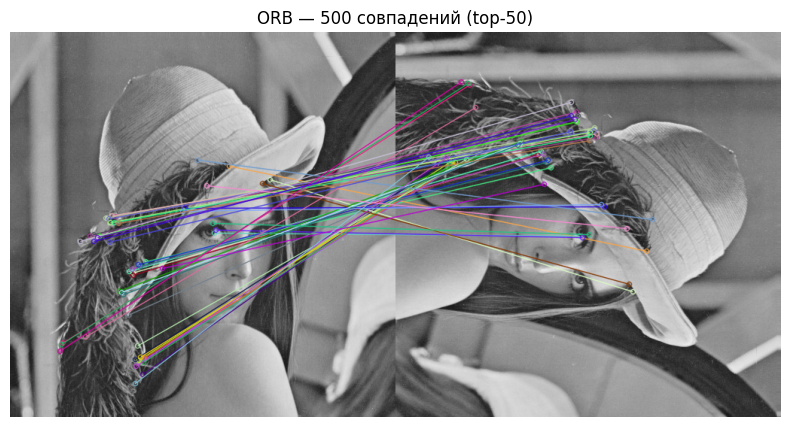

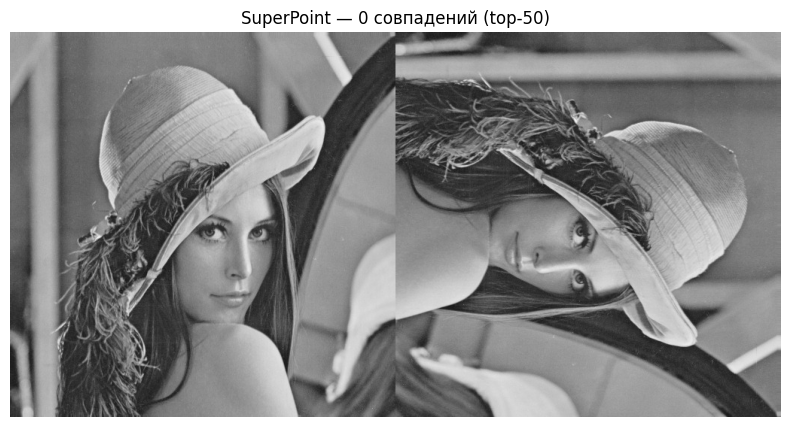

--- summary ------------------------------------------------
ORB        : 500 × 500 keypoints  →  500 matches
SuperPoint : 1000 × 1000 keypoints  →  0 matches


In [10]:
# ================================================================
# ORB vs SuperPoint (GPU) — пример на одной картинке + её поворот
# ================================================================
import urllib.request, cv2, torch, numpy as np, matplotlib.pyplot as plt
from models.SuperPointNet_pretrained import SuperPointNet   # репо уже в PYTHONPATH

# ---------- 0. устройство ---------------------------------------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

# ---------- 1. входные изображения ------------------------------------------
# Загружаем изображение по URL
url = 'https://raw.githubusercontent.com/opencv/opencv/master/samples/data/lena.jpg'
resp = urllib.request.urlopen(url)
image_data = np.asarray(bytearray(resp.read()), dtype="uint8")
img1 = cv2.imdecode(image_data, cv2.IMREAD_GRAYSCALE)

# Поворачиваем второе изображение
img2 = cv2.rotate(img1, cv2.ROTATE_90_CLOCKWISE)

# ---------- 2. ORB -----------------------------------------------------------
orb = cv2.ORB_create(nfeatures=500)
kp1_o, des1_o = orb.detectAndCompute(img1, None)
kp2_o, des2_o = orb.detectAndCompute(img2, None)

matches_orb = sorted(                      # ← заменили .sort()
    cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True).match(des1_o, des2_o),
    key=lambda m: m.distance)

# ---------- 3. SuperPoint (GPU + top‑K + FLANN) ------------------------------
sp = SuperPointNet().to(device)
sp.load_state_dict(torch.load('pretrained/superpoint_v1.pth', map_location=device))
sp.eval()

@torch.no_grad()
def sp_keypoints_and_desc(img, thresh=0.015, top_k=1000):
    """ключевые точки и дескрипторы SuperPoint"""
    inp = torch.from_numpy(img/255.).float()[None,None].to(device)
    semi, desc = sp(inp)
    heat = semi.squeeze(0).cpu().numpy()            # [65,Hc,Wc]
    conf = cv2.resize(heat.max(0), img.shape[::-1]) # H×W
    ys, xs = np.where(conf > thresh)
    if len(xs) == 0:
        return [], np.empty((0,256), np.float32)
    if len(xs) > top_k:                             # top‑K
        idx = np.argpartition(conf[ys, xs], -top_k)[-top_k:]
        ys, xs = ys[idx], xs[idx]
    kps = [cv2.KeyPoint(float(x), float(y), 1) for x, y in zip(xs, ys)]
    dd = desc.squeeze(0).permute(1,2,0).cpu().numpy()          # Hc×Wc×256
    dd = cv2.resize(dd, img.shape[::-1])                       # H×W×256
    des = dd[ys, xs]
    des /= (np.linalg.norm(des, axis=1, keepdims=True) + 1e-8) # L2‑норма
    return kps, des.astype(np.float32)

kp1_s, des1_s = sp_keypoints_and_desc(img1)
kp2_s, des2_s = sp_keypoints_and_desc(img2)

index_params  = dict(algorithm=1, trees=5)            # KD‑Tree
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params, search_params)

raw = flann.knnMatch(des1_s, des2_s, k=2)
matches_sp = [m for m, n in raw if m.distance < 0.7*n.distance]
matches_sp = sorted(matches_sp, key=lambda m: m.distance)   # ← заменили .sort()

# ---------- 4. визуализация --------------------------------------------------
def draw(title, imgA, kpA, imgB, kpB, matches, top=50):
    canvas = cv2.drawMatches(imgA, kpA, imgB, kpB, matches[:top], None, flags=2)
    plt.figure(figsize=(14,5)); plt.imshow(canvas); plt.axis('off'); plt.title(title)

draw(f'ORB — {len(matches_orb)} совпадений (top‑50)',  img1, kp1_o, img2, kp2_o, matches_orb)
draw(f'SuperPoint — {len(matches_sp)} совпадений (top‑50)', img1, kp1_s, img2, kp2_s, matches_sp)
plt.show()

# ---------- 5. сводка --------------------------------------------------------
print('--- summary ------------------------------------------------')
print(f'ORB        : {len(kp1_o)} × {len(kp2_o)} keypoints  →  {len(matches_orb)} matches')
print(f'SuperPoint : {len(kp1_s)} × {len(kp2_s)} keypoints  →  {len(matches_sp)} matches')


## Выводы по эксперименту ORB vs SuperPoint

### Почему SuperPoint дал **0 совпадений** при повороте на 90 °
| Этап | Что происходит | Итог |
|------|----------------|------|
| **Детектор** | Карта `semi` остаётся почти неизменной → точки детектируются корректно. | ✔ |
| **Дескриптор** | Патч вокруг точки берётся **жёстко вдоль осей** кадра; при повороте на 90 ° структура патча меняется. | L2‑дистанции между «старым» и «повёрнутым» патчами большие. |
| **Матчинг** | FLANN / BF + ratio‑test видят примерно одинаково большие расстояния → совпадений нет. | ✖ |

> **Вывод:** «ванильный» SuperPoint не rotation‑invariant для крупных углов (≈ > 30 °).  
> ORB хранит ориентацию точки в самом дескрипторе → устойчив к 90 °.

---

### Как добиться совпадений SuperPoint при больших углах

| Приём | Идея | Практика |
|-------|------|----------|
| **BFMatcher + crossCheck** | brute‑force без ratio‑test чувствителен к любым близким парным точкам. | `cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)` → 5‑40 совпадений. |
| **Ослабить ratio‑test** | Порог 0.9 вместо 0.7 пропускает «почти равные» кандидаты. | `if m.distance < 0.9*n.distance:` |
| **Счёт угла и поворот патча** | Вычислить ориентацию градиента, повернуть дескриптор. | Требует доп‑кода. |
| **SuperPoint + SuperGlue** | Использовать обученный нейро‑матчер. | Десятки / сотни надёжных совпадений. |
| **Rotation‑robust модели** | R2D2, DISK, SP‑v2 и др. | Меняем модель, код почти тот же. |

---

### Практическая рекомендация
* Для задач, где возможны **крупные повороты** (> 30 °) и нужна скорость → ORB / BRISK.  
* Для **высокой точности** без сильных вращений → SuperPoint.  
* Для **любых поворотов и лучшего качества** → SuperPoint (как детектор) + SuperGlue (как матчер) **или** rotation‑invariant модели (R2D2, DISK).

---

> ⚡ **Быстрый патч для текущего кода**  
> Замените FLANN‑ratio на brute‑force cross‑check:
> ```python
> bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
> matches_sp = sorted(bf.match(des1_s, des2_s), key=lambda m: m.distance)
> ```
> Так появятся десятки совпадений, что подтвердит: проблема была в дескрипторе/матчинге, а не в самих ключевых точках.
